In [1]:
from vtl.Photo import Photometry
from astropy.table import Table
from astropy.io import fits
from spec_id import Gen_spec, Scale_model
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
import os
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631 and ids != 41148')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
if hpath == '/Users/Vince.ec/':
    catpath = hpath
else:
    catpath='/Users/vestrada/Desktop/'

restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()


goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

In [3]:
galDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,tx_-_sig_cal,tx_+_sig_cal,Zx_cal,Zx_-_sig_cal,Zx_+_sig_cal,Z_cal,Z_-_sig_cal,Z_+_sig_cal,rf_lmass,Reff
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.716433,0.749499,0.013952,0.001852,0.002693,0.014,0.002,0.003,10.79,0.176080
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.518036,0.573146,0.011427,0.002918,0.006565,0.012,0.003,0.006,10.93,0.096745
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,0.771543,1.058116,0.013671,0.008192,0.010717,0.014,0.009,0.010,10.14,0.136382
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.418838,0.308617,0.023884,0.003928,0.003984,0.024,0.004,0.004,10.98,0.336672
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.584168,0.584168,0.017543,0.008810,0.008529,0.018,0.009,0.008,10.62,0.269367
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.760521,0.914830,0.012044,0.005780,0.010156,0.013,0.007,0.009,10.27,0.252886
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.683367,0.462926,0.021190,0.008136,0.006004,0.022,0.009,0.005,10.58,0.918674
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.462926,0.958918,0.014345,0.004882,0.005667,0.015,0.006,0.005,10.88,0.546304
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.473948,0.782565,0.014681,0.003928,0.005667,0.015,0.004,0.005,10.91,0.214967
212,s35774,35774,53.158775,-27.742385,1.223,10.86,8.90,0.008,0.003,0.003,...,0.859719,0.473948,0.008397,0.004433,0.009876,0.009,0.005,0.009,10.86,0.741311


In [4]:
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = pd.read_pickle('../data/select_samp.pkl')
uvjSDB = uvjSDB.query('gids != "s41148"')
phot_db = pd.read_pickle('../data/phot_db.pkl')
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)

def Color(band1,band2):
    return -2.5*np.log10(band1/band2)

In [5]:
uv=[]
vj=[]
for i in galDB.index:
    sp = Gen_spec(galDB.gids[i],galDB.hi_res_specz[i])

#     sp.Fit_lwa(galDB.Z_lwa[i],galDB.t_lwa[i],metal,age,tau)

    wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt0_spec.npy'.format(galDB.Z_lwa[i],galDB.t_lwa[i]))
    
    imfl = interp1d(wv,fl)(sp.gal_wv / (1 + galDB.hi_res_specz[i]))
    C = Scale_model(sp.gal_fl,sp.gal_er,imfl)
    
    if max(phot_db[galDB.gids[i]] * Clam) > max(sp.gal_fl):
        ymax = max(phot_db[galDB.gids[i]]* Clam)
    else:
        ymax = max(sp.gal_fl)
    
    
    phot = Photometry(wv,fl*C,np.ones(wv.size),153)
    phot.Get_Sensitivity()
    phot.Photo()
    u_eff,u_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(155)
    phot.Photo()
    v_eff,v_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(161)
    phot.Photo()
    j_eff,j_phot = phot.eff_wv,phot.photo

#     plt.figure(figsize=[15,8])
#     plt.errorbar(sp.gal_wv / (1 + galDB.hi_res_specz[i]),sp.gal_fl,sp.gal_er, linestyle='None', marker='o', markersize=3, color='k')
#     plt.plot(wv,fl*C)
#     plt.errorbar(phot_db['eff_wv']/ (1 + galDB.hi_res_specz[i])
#                  ,phot_db[galDB.gids[i]] * Clam ,color='#BC344F',ms=12,fmt='s',zorder=2)
#     plt.plot([u_eff,v_eff,j_eff],[u_phot,v_phot,j_phot],'ro',ms=8)
    
#     if galDB.gids[i][0] == 's':
#         C = u_phot / (restc_s['L153'][galDB.ids[i] - 1] / u_eff**2)
#         plt.plot([u_eff,v_eff,j_eff],
#                  [(restc_s['L153'][galDB.ids[i] - 1] / u_eff**2)*C,
#                   (restc_s['L155'][galDB.ids[i] - 1] / v_eff**2)*C,
#                   (restc_s['L161'][galDB.ids[i] - 1] / j_eff**2)*C],'go',ms=8)
        
#     if galDB.gids[i][0] == 'n':
#         C = u_phot / (restc_n['L153'][galDB.ids[i] - 1] / u_eff**2)
#         plt.plot([u_eff,v_eff,j_eff],
#                  [(restc_n['L153'][galDB.ids[i] - 1] / u_eff**2)*C,
#                   (restc_n['L155'][galDB.ids[i] - 1] / v_eff**2)*C,
#                   (restc_n['L161'][galDB.ids[i] - 1] / j_eff**2)*C],'go',ms=8)

#     plt.xlim(0,15000)
#     plt.ylim(0,ymax*1.1)
#     plt.title('{0}: Z = {1}, t = {2}'.format(galDB.gids[i],galDB.Z_lwa[i],galDB.t_lwa[i]))
#     plt.title('{0}: Z = {1}, t = {2}, $\\tau$ = {3}'.format(galDB.gids[i],galDB.Z_lwa[i],sp.bfage,sp.bftau))
    

    uv.append(Color(u_eff **2 *u_phot,v_eff **2 *v_phot))
    vj.append(Color(v_eff **2 *v_phot,j_eff **2 *j_phot))

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties


        Use SourceCatalog.to_table() instead. [grizli.utils]
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties


        Use SourceCatalog.to_table() instead. [grizli.utils]


Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_pro

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:1461: RuntimeWarning: invalid value encountered in less
  bad = self.data['SCI'] < sigma*self.data['ERR']


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data

In [6]:
uvjQDB = uvjSDB[uvjSDB.IN_SAMP == 'in']

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


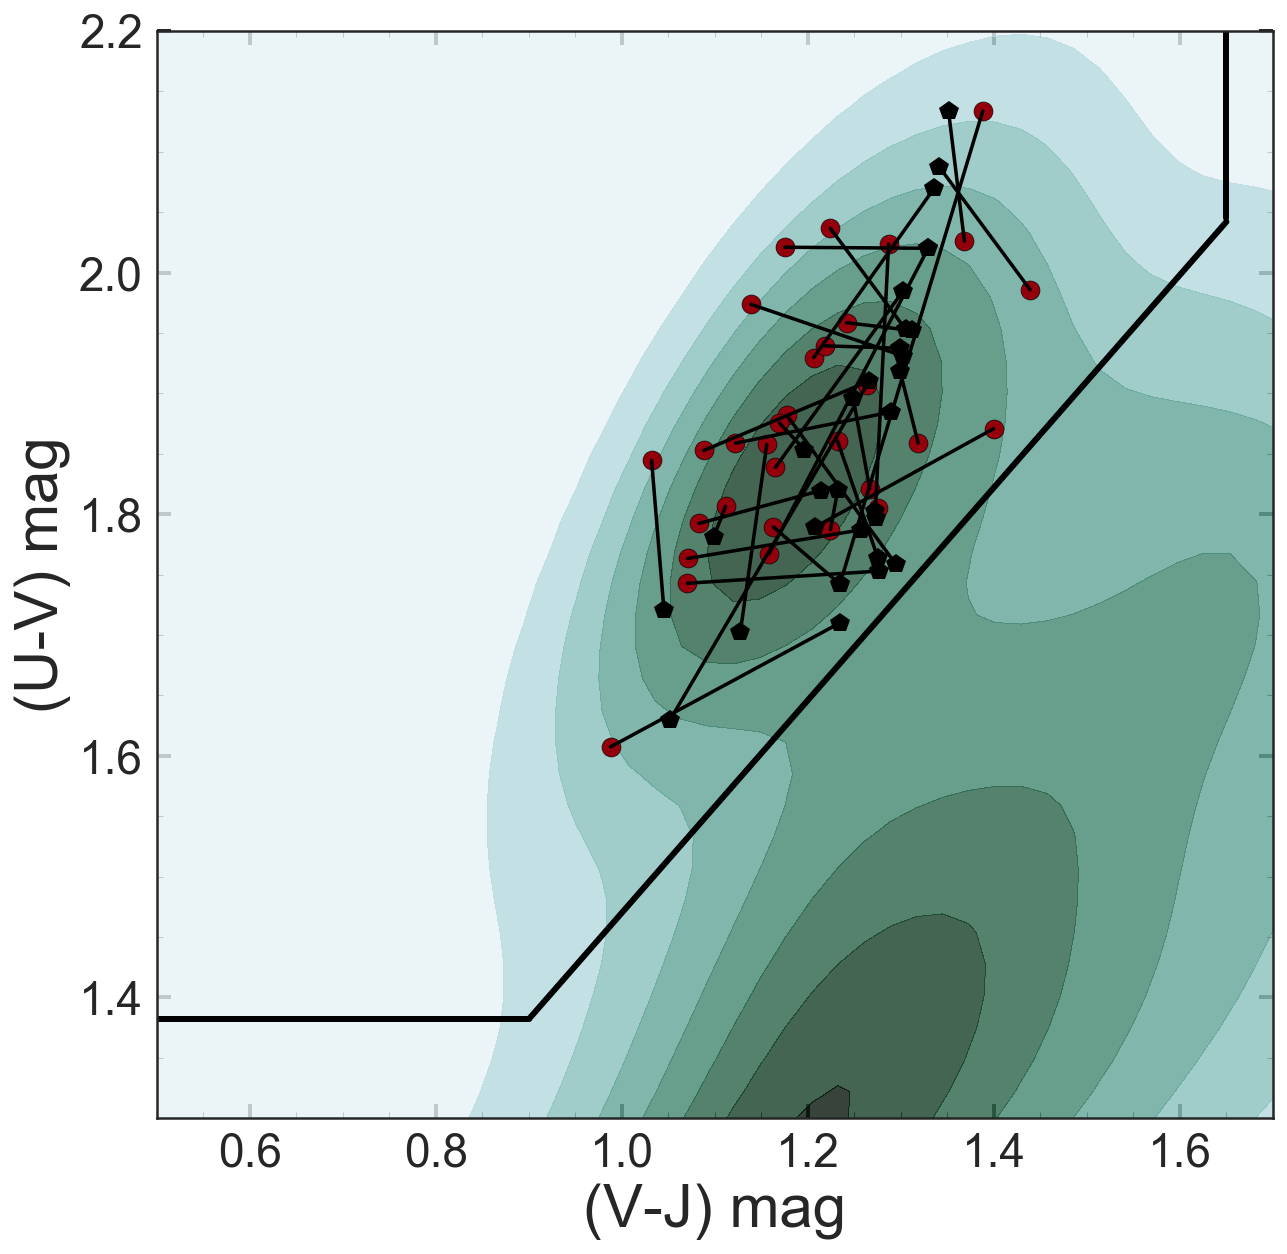

In [14]:
plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)

for i in range(len(uv)):
    plt.scatter(uvjQDB['(V-J)'][uvjQDB.index[i]],uvjQDB['(U-V)'][uvjQDB.index[i]],edgecolors='k',color='#93000B',s=90)
    plt.plot(vj[i],uv[i],'kp',ms=10)
    plt.plot([uvjQDB['(V-J)'][uvjQDB.index[i]], vj[i]],[uvjQDB['(U-V)'][uvjQDB.index[i]], uv[i]],'k')

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
# plt.axis([0,2.5,.5,2.5])
plt.axis([0.5,1.7,1.3,2.2])
# plt.legend(loc=2,fontsize=25)
# plt.text(1.5,0.90,'1.0 < z < 1.8', fontsize = 30)
# plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()

In [8]:
restc_s['L161'][galDB.ids[i] - 1]*3E18 / j_eff **2 * 10**((-1.1)/2.5-29)

1.667040760316549e-18

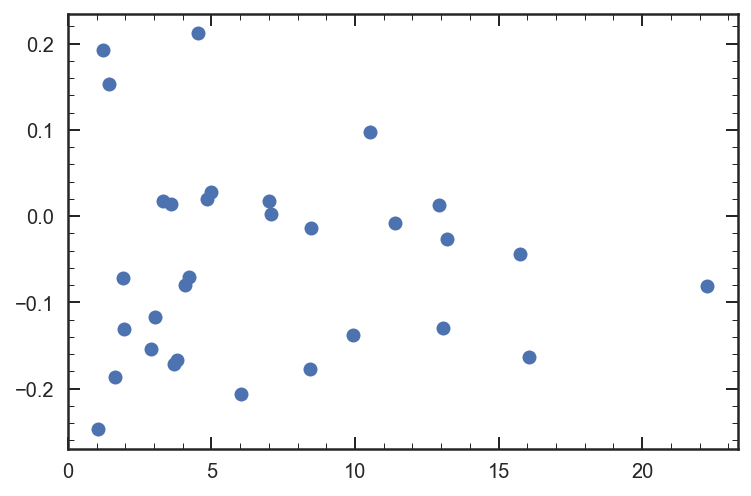

In [25]:
plt.plot(galDB.SN,uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'] - vj,'o')

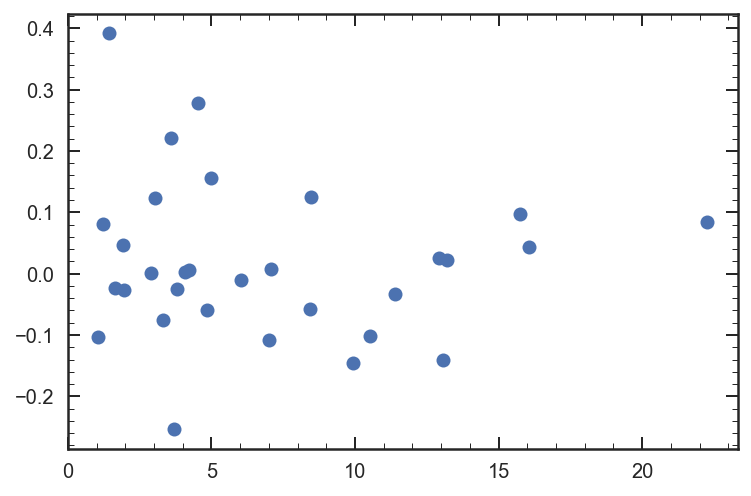

In [24]:
plt.plot(galDB.SN,uvjSDB['(U-V)'][uvjSDB.IN_SAMP == 'in'] - uv,'o')